<a href="https://colab.research.google.com/github/Joelalvazer/probabilidad/blob/main/UNIDAD%206/U_5_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Lectura y acumulación de datos terminada.

===== ESTADÍSTICA DESCRIPTIVA =====

Total de casos en la base: 12634194

Casos por resultado (RESULTADO_ANTIGENO):
  Positivo: 1774708
  Negativo: 5853547
  Pendiente: 5005939
  No aplica: 0

Tipo de paciente (códigos tal cual vienen en la base):
{'Ambulatorio': 11543303, 'Hospitalizado': 1090891}

Pacientes embarazadas (valor '1' en embarazo): 122583
Pacientes indígenas (valor '1' en indigena): 35240

===== Probabilidades simples de comorbilidades =====


,Probabilidad
DIABETES,0.082194
EPOC,0.007317
ASMA,0.020884
HIPERTENSIÓN,0.000000
CARDIOVASCULAR,0.010639
OBESIDAD,0.094428
RENAL_CRONICA,0.010280
TABAQUISMO,0.068478


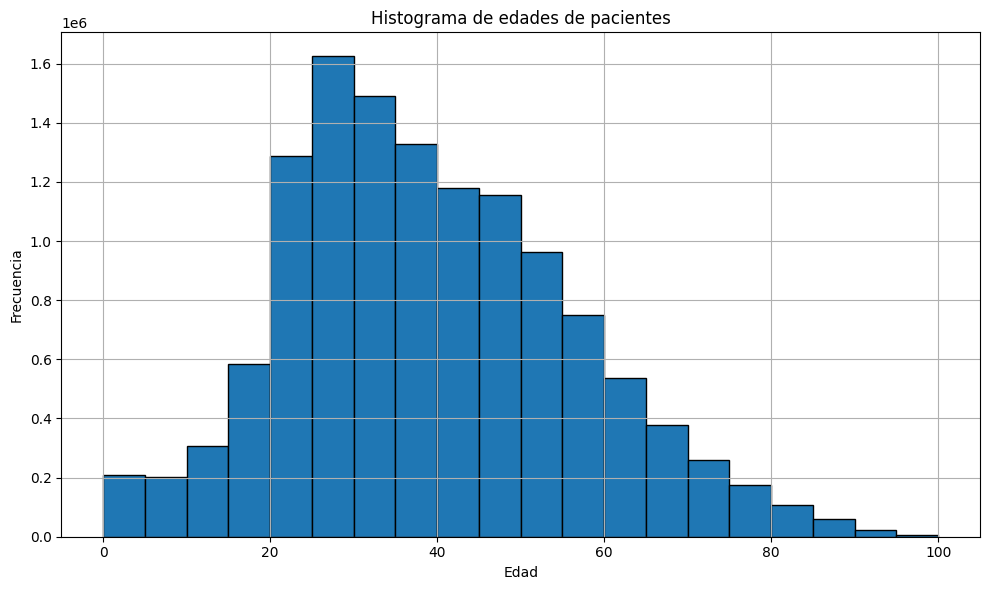

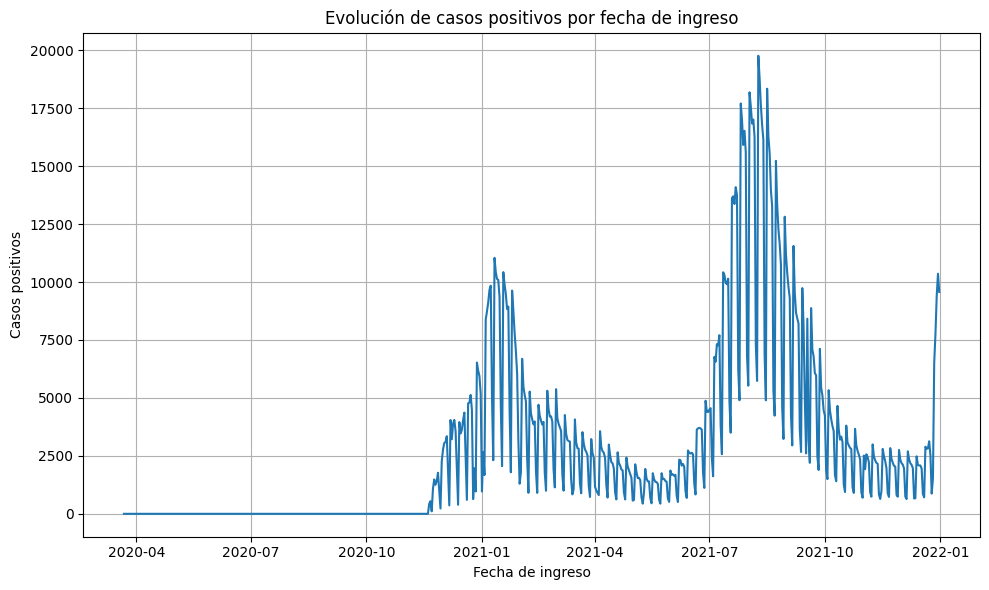

<Figure size 1000x600 with 0 Axes>

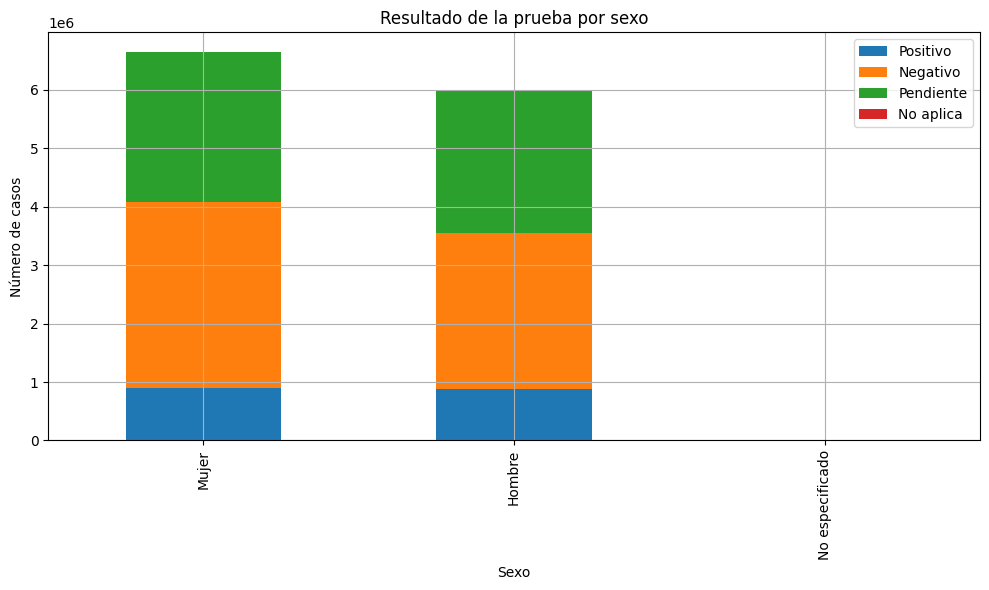

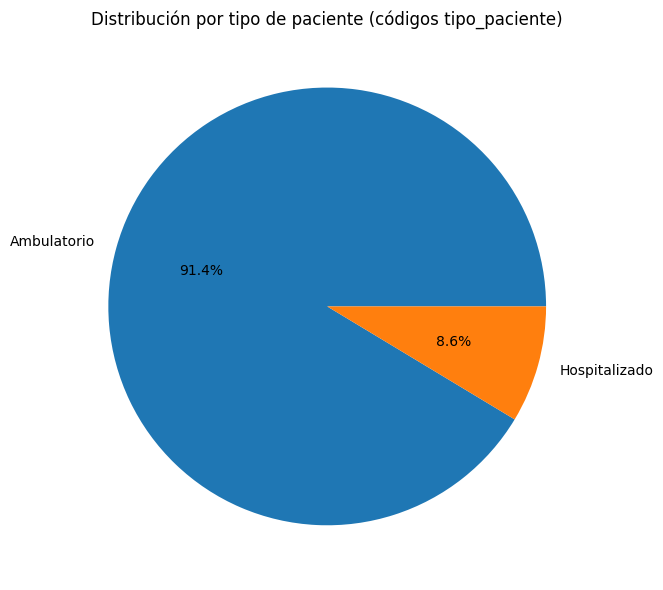

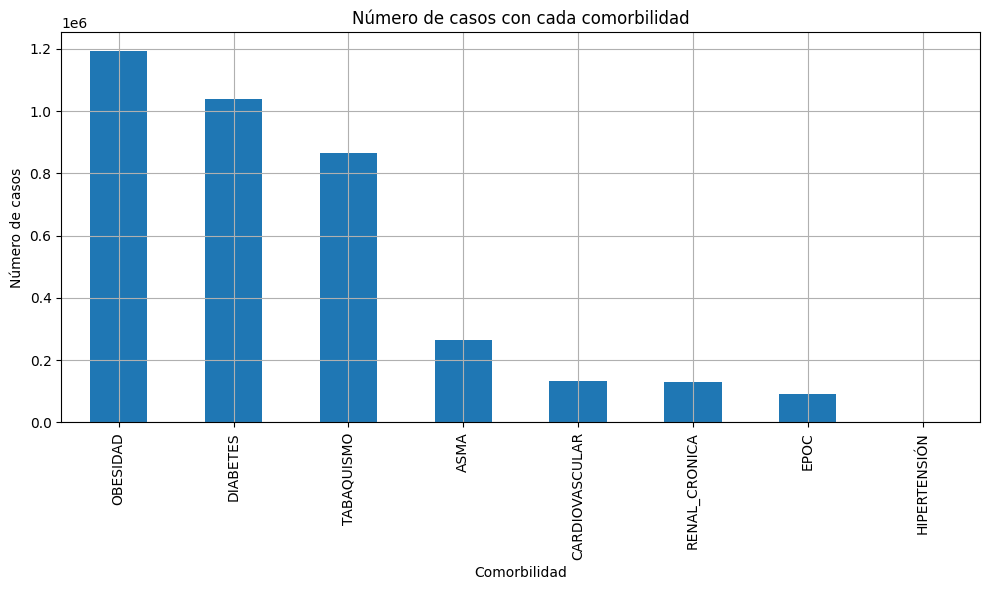


===== Probabilidades condicionales P(comorbilidad | entidad_nacional) =====


""



===== Distribución normal (casos positivos por estado) =====
Probabilidad de tener entre 2000 y 3000 casos positivos: 0.5079
Equivale a: 50.79%


In [8]:
# ============================================================
# PROYECTO FINAL - ANÁLISIS ESTADÍSTICO COVID-19 EN PYTHON
# Adaptado a columnas:
# sector, sexo, entidad_nacional, tipo_paciente, fecha_ingreso,
# fecha_def, intubado, neumonia, edad, embarazo, indigena,
# diabetes, epoc, asma, hipertensión, cardiovascular, obesidad,
# renal_cronica, tabaquismo, RESULTADO_ANTIGENO, uci
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from IPython.display import display

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True

# ------------------------------------------------------------
# Montar Google Drive
# ------------------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')


ruta_csv = "/content/drive/MyDrive/Covid/covid2020-2021-codificado.csv"

#
# ------------------------------------------------------------
# Funciones auxiliares para clasificar variables
# ------------------------------------------------------------
def clasificar_resultado(x):
    """
    Normaliza RESULTADO_ANTIGENO a categorías:
    Positivo / Negativo / Pendiente / No aplica
    Soporta valores tipo: 1, 2, 3, 'si', 'no', 'pendiente', etc.
    """
    if pd.isna(x):
        return "No aplica"
    s = str(x).strip().lower()
    if s in ["1", "si", "sí", "positivo", "pos"]:
        return "Positivo"
    elif s in ["2", "no", "negativo"]:
        return "Negativo"
    elif s in ["3", "pendiente", "pend"]:
        return "Pendiente"
    else:
        return "No aplica"


def clasificar_sexo(x):
    """
    Normaliza SEXO a: Mujer / Hombre / No especificado
    Soporta códigos numéricos y texto.
    """
    if pd.isna(x):
        return "No especificado"
    s = str(x).strip().lower()
    if s in ["1", "mujer", "f", "femenino", "femenina"]:
        return "Mujer"
    elif s in ["2", "hombre", "m", "masculino", "masculina"]:
        return "Hombre"
    else:
        return "No especificado"

def normalize_binary_column(x):
    """
    Normaliza valores a 1 (Sí) o 0 (No/No aplica).
    Asume que 1, '1', 'si', 'sí', 'true', 'yes' significa 'Sí', cualquier otro valor es 'No' o 'No aplica'.
    """
    if pd.isna(x):
        return 0
    s = str(x).strip().lower()
    if s in ["1", "si", "sí", "true", "yes"]:
        return 1
    else:
        return 0


# ------------------------------------------------------------
# Acumuladores globales
# ------------------------------------------------------------
total_casos = 0

# Conteo por resultado
conteo_resultado = {
    "Positivo": 0,
    "Negativo": 0,
    "Pendiente": 0,
    "No aplica": 0
}

# Tipo de paciente (1 ambulatorio, 2 hospitalizado; si cambia, se verá en la salida)
conteo_tipo_paciente = {}

# Embarazo e indígena (asumiendo 1 = Sí)
total_embarazadas = 0
total_indigenas = 0

# Para gráficos
casos_por_estado = {}   # positivos por entidad_nacional
conteo_edades = {}      # histograma
casos_por_fecha = {}    # evolución de positivos

# Sexo vs resultado (usamos las categorías normalizadas)
conteo_sexo_resultado = {
    "Mujer":   {"Positivo": 0, "Negativo": 0, "Pendiente": 0, "No aplica": 0},
    "Hombre":  {"Positivo": 0, "Negativo": 0, "Pendiente": 0, "No aplica": 0},
    "No especificado": {"Positivo": 0, "Negativo": 0, "Pendiente": 0, "No aplica": 0}
}

# Comorbilidades
comorbilidades = [
    "DIABETES",
    "EPOC",
    "ASMA",
    "HIPERTENSIÓN",
    "CARDIOVASCULAR",
    "OBESIDAD",
    "RENAL_CRONICA",
    "TABAQUISMO"
]

conteo_comorbilidad = {c: 0 for c in comorbilidades}

# Probabilidad condicional: por entidad y comorbilidad
total_por_entidad = {}                 # entidad_nacional -> total casos
comorb_por_entidad = {c: {} for c in comorbilidades}  # c -> {entidad: casos con comorbilidad}


# ------------------------------------------------------------
# Lectura por CHUNKS (para archivo muy grande)
# ------------------------------------------------------------
chunksize = 500_000  # puedes ajustar si te da RAM o tiempo

for chunk in pd.read_csv(
    ruta_csv,
    chunksize=chunksize,
    low_memory=False
):
    df = chunk.copy()

    # Normalizamos nombres de columnas a MAYÚSCULAS por seguridad
    df.columns = df.columns.str.upper()

    # Aseguramos que existan las columnas que vamos a usar
    # (si falta alguna, se ignora silenciosamente)
    cols = df.columns

    # Total de casos
    total_casos += len(df)

    # Crear columnas categóricas estándar
    if "RESULTADO_ANTIGENO" in cols:
        df["resultado_cat"] = df["RESULTADO_ANTIGENO"].apply(clasificar_resultado)
    elif "RESULTADO_ANTÍGENO" in cols:
        df["resultado_cat"] = df["RESULTADO_ANTÍGENO"].apply(clasificar_resultado)
    else:
        # Si no existe, todo se marca como No aplica (muy raro pero por seguridad)
        df["resultado_cat"] = "No aplica"

    if "SEXO" in cols:
        df["sexo_cat"] = df["SEXO"].apply(clasificar_sexo)
    else:
        df["sexo_cat"] = "No especificado"

    # -----------------------------
    # Conteo de resultados globales
    # -----------------------------
    for res, v in df["resultado_cat"].value_counts().items():
        if res in conteo_resultado:
            conteo_resultado[res] += v
        else:
            conteo_resultado[res] = v

    # -----------------------------
    # Tipo de paciente
    # -----------------------------
    if "TIPO_PACIENTE" in cols:
        for tp, v in df["TIPO_PACIENTE"].value_counts().items():
            conteo_tipo_paciente[tp] = conteo_tipo_paciente.get(tp, 0) + v

    # -----------------------------
    # Embarazo (1 = sí habitualmente)
    # -----------------------------
    if "EMBARAZO" in cols:
        total_embarazadas += df["EMBARAZO"].apply(normalize_binary_column).sum()

    # -----------------------------
    # Indígena (1 = sí habitualmente)
    # -----------------------------
    if "INDIGENA" in cols:
        total_indigenas += df["INDIGENA"].apply(normalize_binary_column).sum()

    # -----------------------------
    # Casos positivos por estado
    # -----------------------------
    if "ENTIDAD_NACIONAL" in cols:
        df_pos = df[df["resultado_cat"] == "Positivo"]
        for ent, v in df_pos["ENTIDAD_NACIONAL"].value_counts().items():
            casos_por_estado[ent] = casos_por_estado.get(ent, 0) + v

    # -----------------------------
    # Histograma por edad
    # -----------------------------
    if "EDAD" in cols:
        for edad, v in df["EDAD"].value_counts().items():
            conteo_edades[edad] = conteo_edades.get(edad, 0) + v

    # -----------------------------
    # Casos positivos por fecha de ingreso
    # -----------------------------
    if "FECHA_INGRESO" in cols:
        df_pos_fecha = df[df["resultado_cat"] == "Positivo"]
        for f, v in df_pos_fecha["FECHA_INGRESO"].value_counts().items():
            casos_por_fecha[f] = casos_por_fecha.get(f, 0) + v

    # -----------------------------
    # Barras apiladas sexo vs resultado
    # -----------------------------
    tabla = df.groupby(["sexo_cat", "resultado_cat"]).size()
    for (sx, res), v in tabla.items():
        if sx not in conteo_sexo_resultado:
            conteo_sexo_resultado[sx] = {"Positivo": 0, "Negativo": 0, "Pendiente": 0, "No aplica": 0}
        if res not in conteo_sexo_resultado[sx]:
            conteo_sexo_resultado[sx][res] = 0
        conteo_sexo_resultado[sx][res] += v

    # -----------------------------
    # Comorbilidades (prob simple)
    # -----------------------------
    for c in comorbilidades:
        if c in cols:
            conteo_comorbilidad[c] += df[c].apply(normalize_binary_column).sum()

    # -----------------------------
    # Totales por entidad y comorbilidad
    # -----------------------------
    if "ENTIDAD_NACIONAL" in cols:
        for ent, v in df["ENTIDAD_NACIONAL"].value_counts().items():
            total_por_entidad[ent] = total_por_entidad.get(ent, 0) + v

        for c in comorbilidades:
            if c in cols:
                df_c = df[df[c].apply(normalize_binary_column) == 1]
                for ent, v in df_c["ENTIDAD_NACIONAL"].value_counts().items():
                    if ent not in comorb_por_entidad[c]:
                        comorb_por_entidad[c][ent] = 0
                    comorb_por_entidad[c][ent] += v

print("✅ Lectura y acumulación de datos terminada.")

# ============================================================
# ESTADÍSTICA DESCRIPTIVA
# ============================================================
print("\n===== ESTADÍSTICA DESCRIPTIVA =====\n")
print("Total de casos en la base:", total_casos)
print()

print("Casos por resultado (RESULTADO_ANTIGENO):")
for k, v in conteo_resultado.items():
    print(f"  {k}: {v}")
print()

print("Tipo de paciente (códigos tal cual vienen en la base):")
print(conteo_tipo_paciente)
print()

print("Pacientes embarazadas (valor '1' en embarazo):", total_embarazadas)
print("Pacientes indígenas (valor '1' en indigena):", total_indigenas)

# Probabilidad simple de comorbilidades
prob_simple = {c: conteo_comorbilidad[c] / total_casos for c in comorbilidades}
df_prob_simple = pd.DataFrame.from_dict(prob_simple, orient='index', columns=['Probabilidad'])
print("\n===== Probabilidades simples de comorbilidades =====")
display(df_prob_simple)

# ============================================================
# GRÁFICOS
# ============================================================

# 1) Barras horizontales por estado (positivos)
if len(casos_por_estado) > 0:
    df_estado = pd.DataFrame.from_dict(casos_por_estado, orient='index', columns=['Casos_Positivos'])
    df_estado = df_estado.sort_values("Casos_Positivos", ascending=True)

    plt.figure()
    df_estado['Casos_Positivos'].plot(kind='barh')
    plt.title("Casos positivos por entidad federativa (entidad_nacional)")
    plt.xlabel("Número de casos positivos")
    plt.ylabel("Entidad federativa")
    plt.tight_layout()
    plt.show()

# 2) Histograma por edad
if len(conteo_edades) > 0:
    edades = []
    for edad, freq in conteo_edades.items():
        try:
            e = int(edad)
            if e >= 0:
                edades.extend([e] * int(freq))
        except:
            pass

    plt.figure()
    plt.hist(edades, bins=range(0, 101, 5), edgecolor='black')
    plt.title("Histograma de edades de pacientes")
    plt.xlabel("Edad")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

# 3) Gráfico de líneas por fecha (evolución de positivos)
if len(casos_por_fecha) > 0:
    df_fecha = pd.DataFrame.from_dict(casos_por_fecha, orient='index', columns=['Casos_Positivos'])
    df_fecha.index = pd.to_datetime(df_fecha.index, errors='coerce')
    df_fecha = df_fecha.sort_index()

    plt.figure()
    plt.plot(df_fecha.index, df_fecha['Casos_Positivos'])
    plt.title("Evolución de casos positivos por fecha de ingreso")
    plt.xlabel("Fecha de ingreso")
    plt.ylabel("Casos positivos")
    plt.tight_layout()
    plt.show()

# 4) Barras apiladas por sexo y resultado
df_sexo_res = pd.DataFrame.from_dict(conteo_sexo_resultado, orient='index')
plt.figure()
df_sexo_res.plot(kind='bar', stacked=True)
plt.title("Resultado de la prueba por sexo")
plt.xlabel("Sexo")
plt.ylabel("Número de casos")
plt.tight_layout()
plt.show()

# 5) Gráfico circular por tipo de paciente
if len(conteo_tipo_paciente) > 0:
    etiquetas_tp = [str(k) for k in conteo_tipo_paciente.keys()]
    valores_tp = list(conteo_tipo_paciente.values())

    plt.figure()
    plt.pie(valores_tp, labels=etiquetas_tp, autopct='%1.1f%%')
    plt.title("Distribución por tipo de paciente (códigos tipo_paciente)")
    plt.tight_layout()
    plt.show()

# 6) Gráfico de barras por comorbilidad
df_comorb = pd.DataFrame.from_dict(conteo_comorbilidad, orient='index', columns=['Casos'])
df_comorb = df_comorb.sort_values("Casos", ascending=False)

plt.figure()
df_comorb['Casos'].plot(kind='bar')
plt.title("Número de casos con cada comorbilidad")
plt.ylabel("Número de casos")
plt.xlabel("Comorbilidad")
plt.tight_layout()
plt.show()

# ============================================================
# PROBABILIDADES CONDICIONALES P(comorbilidad | entidad)
# ============================================================
filas_prob_cond = []
for ent, total_ent in total_por_entidad.items():
    fila = {"entidad_nacional": ent}
    for c in comorbilidades:
        # Necesitamos el conteo normalizado para esta entidad y comorbilidad
        casos_c_ent = comorb_por_entidad[c].get(ent, 0)
        fila[c] = casos_c_ent / total_ent if total_ent > 0 else 0
    filas_prob_cond.append(fila)

df_prob_cond = pd.DataFrame(filas_prob_cond)
print("\n===== Probabilidades condicionales P(comorbilidad | entidad_nacional) =====")
display(df_prob_cond.head())

# ============================================================
# EJERCICIO DE DISTRIBUCIÓN NORMAL (dato teórico del PDF)
# ============================================================
# Media = 2360, Desviación estándar = 714
# ¿Probabilidad de que un estado tenga entre 2000 y 3000 casos positivos?
media = 2360
desv = 714

p_2000_3000 = norm.cdf(3000, loc=media, scale=desv) - norm.cdf(2000, loc=media, scale=desv)
print("\n===== Distribución normal (casos positivos por estado) =====")
print(f"Probabilidad de tener entre 2000 y 3000 casos positivos: {p_2000_3000:.4f}")
print(f"Equivale a: {p_2000_3000*100:.2f}%")

# ============================================================
# FIN DEL CÓDIGO
# ============================================================
